In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F

In [4]:
import torchxrayvision as xrv

In [5]:
d_nih = xrv.datasets.NIH_Dataset(imgpath="/lustre04/scratch/cohenjos/NIH/images-224")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_nih)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [6]:
d_pc = xrv.datasets.PC_Dataset(imgpath="/lustre04/scratch/cohenjos/PC/images-224")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_pc)

{'Granuloma', 'Flattened Diaphragm', 'Bronchiectasis'} will be dropped
Lung Lesion doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


{'Atelectasis': 0.0,
 'Consolidation': 1.0,
 'Infiltration': 1.0,
 'Pneumothorax': 0.0,
 'Edema': 0.0,
 'Emphysema': 0.0,
 'Fibrosis': 0.0,
 'Effusion': 1.0,
 'Pneumonia': 0.0,
 'Pleural_Thickening': 0.0,
 'Cardiomegaly': 0.0,
 'Nodule': 0.0,
 'Mass': 0.0,
 'Hernia': 0.0,
 'Lung Lesion': nan,
 'Fracture': nan,
 'Lung Opacity': nan,
 'Enlarged Cardiomediastinum': nan}

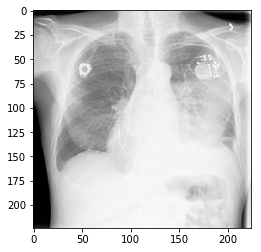

In [7]:
sample = d_nih[40]
plt.imshow(sample["img"][0], cmap="Greys_r");
dict(zip(d_pc.pathologies,sample["lab"]))

In [11]:
# does the model align with the dataset?
dict(zip(model.pathologies,xrv.datasets.default_pathologies))

{'Atelectasis': 'Atelectasis',
 'Consolidation': 'Consolidation',
 'Infiltration': 'Infiltration',
 'Pneumothorax': 'Pneumothorax',
 'Edema': 'Edema',
 'Emphysema': 'Emphysema',
 'Fibrosis': 'Fibrosis',
 'Effusion': 'Effusion',
 'Pneumonia': 'Pneumonia',
 'Pleural_Thickening': 'Pleural_Thickening',
 'Cardiomegaly': 'Cardiomegaly',
 'Nodule': 'Nodule',
 'Mass': 'Mass',
 'Hernia': 'Hernia',
 'Lung Lesion': 'Lung Lesion',
 'Fracture': 'Fracture',
 'Lung Opacity': 'Lung Opacity',
 'Enlarged Cardiomediastinum': 'Enlarged Cardiomediastinum'}

In [8]:
model = xrv.models.DenseNet(weights="all")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(model.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.5355571, 0.0),
 'Consolidation': (0.5541505, 1.0),
 'Infiltration': (0.58542293, 1.0),
 'Pneumothorax': (0.5188316, 0.0),
 'Edema': (0.15621193, 0.0),
 'Emphysema': (0.5120224, 0.0),
 'Fibrosis': (0.5215088, 0.0),
 'Effusion': (0.535236, 1.0),
 'Pneumonia': (0.5335671, 0.0),
 'Pleural_Thickening': (0.5501406, 0.0),
 'Cardiomegaly': (0.20463671, 0.0),
 'Nodule': (0.5491222, 0.0),
 'Mass': (0.7618316, 0.0),
 'Hernia': (0.1438027, 0.0),
 'Lung Lesion': (0.077491745, nan),
 'Fracture': (0.45177895, nan),
 'Lung Opacity': (0.7261822, nan),
 'Enlarged Cardiomediastinum': (0.5274637, nan)}

In [9]:
model = xrv.models.DenseNet(weights="nih")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(model.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.5566849, 0.0),
 'Consolidation': (0.52457345, 1.0),
 'Infiltration': (0.5974177, 1.0),
 'Pneumothorax': (0.5071652, 0.0),
 'Edema': (0.5025493, 0.0),
 'Emphysema': (0.5023997, 0.0),
 'Fibrosis': (0.5037091, 0.0),
 'Effusion': (0.77604365, 1.0),
 'Pneumonia': (0.5019207, 0.0),
 'Pleural_Thickening': (0.62171924, 0.0),
 'Cardiomegaly': (0.5250585, 0.0),
 'Nodule': (0.5426084, 0.0),
 'Mass': (0.6622993, 0.0),
 'Hernia': (0.5013983, 0.0),
 'Lung Lesion': (nan, nan),
 'Fracture': (nan, nan),
 'Lung Opacity': (nan, nan),
 'Enlarged Cardiomediastinum': (nan, nan)}

In [10]:
# small test eval

In [20]:
outs = []
labs = []
with torch.no_grad():
    for i in np.random.randint(0,len(d_nih),100):
        sample = d_nih[i]
        labs.append(sample["lab"])
        out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
        out = torch.sigmoid(out)
        outs.append(out.detach().numpy()[0])

In [21]:
import sklearn, sklearn.metrics
for i in range(14):
    if len(np.unique(np.asarray(labs)[:,i])) > 1:
        auc = sklearn.metrics.roc_auc_score(np.asarray(labs)[:,i], np.asarray(outs)[:,i])
    else:
        auc = "(Only one class observed)"
    print(xrv.datasets.default_pathologies[i], auc)
        

Atelectasis 0.9216589861751152
Consolidation (Only one class observed)
Infiltration 0.5464190981432361
Pneumothorax 0.9292929292929293
Edema (Only one class observed)
Emphysema 0.9494949494949495
Fibrosis 0.6887755102040816
Effusion 0.9284210526315789
Pneumonia (Only one class observed)
Pleural_Thickening 0.9846938775510203
Cardiomegaly 0.9897959183673469
Nodule 0.8723404255319149
Mass 0.9184397163120568
Hernia (Only one class observed)
